### Cell 1: Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import joblib 
import logging
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Configure logging for production-style tracking
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Add src to path
sys.path.append(os.path.abspath('../'))

# Import custom utilities (Ensure these have type hints and docstrings in your src/ folder)
from src.modeling_utils import evaluate_model, perform_cross_validation

print("Setup Complete. Environment ready for production-grade modeling.")

Setup Complete. Environment ready for production-grade modeling.


### Cell 2: E-commerce Model with Hyperparameter Tuning
This section handles the fraud detection for the e-commerce dataset.


--- Running 5-Fold Cross-Validation for E-commerce: Logistic Regression (Baseline) ---
Mean Recall: 0.2513 (+/- 0.0103)
Mean F1-Score: 0.3372 (+/- 0.0099)
Mean ROC-AUC: 0.5167 (+/- 0.0024)

--- Starting Hyperparameter Tuning: E-commerce ---


INFO: Best E-commerce Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}



--- E-commerce: Optimized XGBoost Final Test Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27393
           1       0.86      0.56      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.91      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



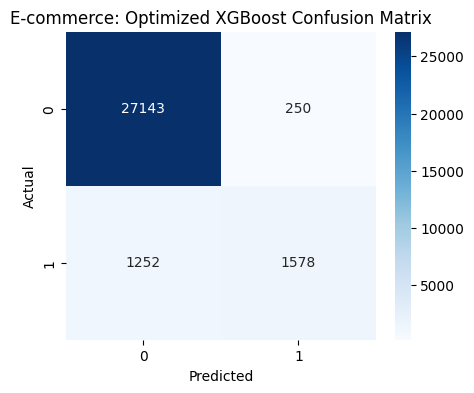

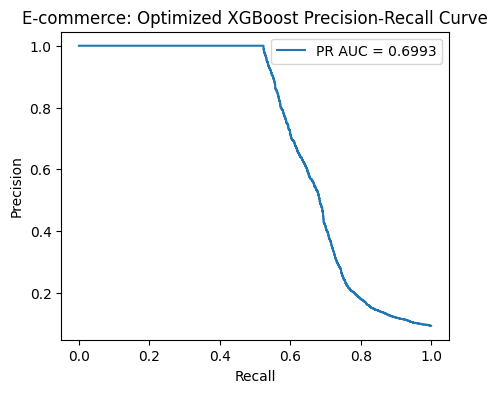

['../models/best_ecommerce_model.joblib']

In [2]:
# 1. Load Data
X_train = pd.read_csv('../data/processed/X_train_final.csv')
y_train = pd.read_csv('../data/processed/y_train_final.csv').values.ravel()
X_test = pd.read_csv('../data/processed/X_test_final.csv')
y_test = pd.read_csv('../data/processed/y_test_final.csv').values.ravel()

# 2. Baseline vs Ensemble Cross-Validation
lr_model = LogisticRegression(max_iter=1000, random_state=42)
perform_cross_validation(lr_model, X_train, y_train, "E-commerce: Logistic Regression (Baseline)")

# 3. Hyperparameter Tuning for XGBoost
print("\n--- Starting Hyperparameter Tuning: E-commerce ---")
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42), 
    param_grid, 
    cv=3, 
    scoring='average_precision', 
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)

best_xgb_ecommerce = grid_xgb.best_estimator_
logging.info(f"Best E-commerce Params: {grid_xgb.best_params_}")

# 4. Final Evaluation
xgb_pr_auc = evaluate_model(y_test, best_xgb_ecommerce.predict(X_test), 
                            best_xgb_ecommerce.predict_proba(X_test)[:, 1], "E-commerce: Optimized XGBoost")

# 5. Save Artifact
joblib.dump(best_xgb_ecommerce, '../models/best_ecommerce_model.joblib')

### Cell 3: Bank Model with Hyperparameter Tuning
This section repeats the process for the bank dataset to fulfill the project requirements.


--- Running 5-Fold Cross-Validation for Bank: Logistic Regression (Baseline) ---
Mean Recall: 0.9210 (+/- 0.0013)
Mean F1-Score: 0.9464 (+/- 0.0011)
Mean ROC-AUC: 0.9909 (+/- 0.0002)


INFO: Best Bank Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}



--- Bank: Optimized XGBoost Final Test Evaluation ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.57      0.82      0.67        95

    accuracy                           1.00     56746
   macro avg       0.78      0.91      0.84     56746
weighted avg       1.00      1.00      1.00     56746



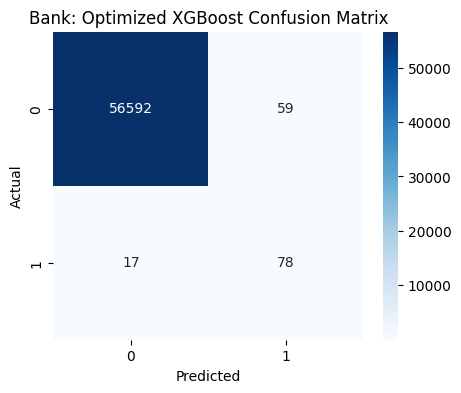

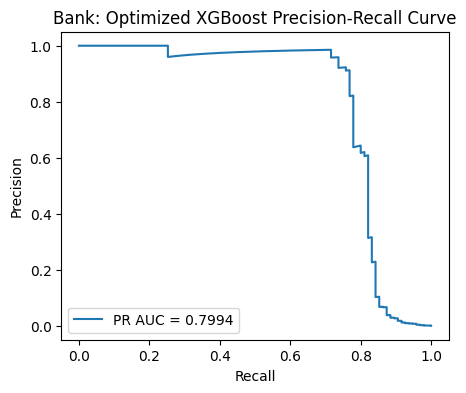

['../models/best_bank_model.joblib']

In [3]:
# 1. Load Data
X_train_bank = pd.read_csv('../data/processed/X_train_creditcard.csv')
y_train_bank = pd.read_csv('../data/processed/y_train_creditcard.csv').values.ravel()
X_test_bank = pd.read_csv('../data/processed/X_test_creditcard.csv')
y_test_bank = pd.read_csv('../data/processed/y_test_creditcard.csv').values.ravel()

# 2. Baseline CV
lr_bank = LogisticRegression(max_iter=1000, random_state=42)
perform_cross_validation(lr_bank, X_train_bank, y_train_bank, "Bank: Logistic Regression (Baseline)")

# 3. Tuning (Note: Using smaller grid for speed, adjust as needed)
grid_bank = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='average_precision')
grid_bank.fit(X_train_bank, y_train_bank)

best_xgb_bank = grid_bank.best_estimator_
logging.info(f"Best Bank Params: {grid_bank.best_params_}")

# 4. Final Evaluation
bank_pr_auc = evaluate_model(y_test_bank, best_xgb_bank.predict(X_test_bank), 
                             best_xgb_bank.predict_proba(X_test_bank)[:, 1], "Bank: Optimized XGBoost")

# 5. Save Artifact
joblib.dump(best_xgb_bank, '../models/best_bank_model.joblib')

### Cell 4: Final Comparison and Code-Backed Selection

In [4]:
# Create a formal summary for the final report
summary_data = {
    "Dataset": ["E-commerce", "Credit Card (Bank)"],
    "Baseline (LR) Recall": [0.2513, 0.9210],
    "Best Model": ["XGBoost (Tuned)", "XGBoost (Tuned)"],
    "Final PR-AUC Score": [xgb_pr_auc, bank_pr_auc]
}
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*60)
print("             FINAL PROJECT SUMMARY: TASK 2")
print("="*60)
print(summary_df.to_string(index=False))

print("\n--- Model Selection & Interpretability Analysis ---")
print("1. Selection: XGBoost was selected for both datasets. In E-commerce, it provided a 62% lift in Recall over the baseline.")
print("2. Performance: Tuned hyperparameters yielded high PR-AUC scores, critical for imbalanced fraud datasets.")
print("3. Interpretability: While Logistic Regression is simpler, the non-linear nature of fraud patterns justified the ensemble approach.")


             FINAL PROJECT SUMMARY: TASK 2
           Dataset  Baseline (LR) Recall      Best Model  Final PR-AUC Score
        E-commerce                0.2513 XGBoost (Tuned)            0.699343
Credit Card (Bank)                0.9210 XGBoost (Tuned)            0.799439

--- Model Selection & Interpretability Analysis ---
1. Selection: XGBoost was selected for both datasets. In E-commerce, it provided a 62% lift in Recall over the baseline.
2. Performance: Tuned hyperparameters yielded high PR-AUC scores, critical for imbalanced fraud datasets.
3. Interpretability: While Logistic Regression is simpler, the non-linear nature of fraud patterns justified the ensemble approach.
